# Practical 1

In [ ]:

from transformers import pipeline

# Load a sentiment-analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

def analyze_sentiment(text):
    # Analyze sentiment
    result = sentiment_analyzer(text)
    return result

if __name__ == "__main__":
    text = "I love using natural language processing to segregate text data!"
    sentiment = analyze_sentiment(text)
    print(sentiment)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9991288781166077}]


# Practical 2

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def chat_with_bot(input_text, history=[]):
    # Indented block within the function
    new_user_input_ids = tokenizer.encode(input_text + tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([torch.cat(history, dim=-1), new_user_input_ids], dim=-1) if history else new_user_input_ids
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    history.append(bot_input_ids)
    return response, history

history = []
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    response, history = chat_with_bot(user_input, history)
    print(f"Bot: {response}")

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

You: How are you?


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Bot: I'm good, how are you?
You: Which is your favourite movie?
Bot: The Departed
You: Favourite singer?
Bot: I don't know, I don't really listen to music.
You: exit


# Practical 3

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, Concatenate, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Load the MovieLens dataset
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
data_path = tf.keras.utils.get_file("ml-latest-small.zip", url, extract=True)
ratings_file = data_path.replace("ml-latest-small.zip", "ml-latest-small/ratings.csv")
ratings = pd.read_csv(ratings_file)

# 2. Preprocess the data
# Encode userId and movieId as integers
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = item_encoder.fit_transform(ratings['movieId'])

num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

# Prepare train and test datasets
X = ratings[['userId', 'movieId']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define the collaborative filtering model
def build_model(num_users, num_movies, embedding_dim=50):
    # User embedding
    user_input = Input(shape=(1,), name="user_input")
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name="user_embedding")(user_input)
    user_vector = Flatten()(user_embedding)

    # Movie embedding
    movie_input = Input(shape=(1,), name="movie_input")
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name="movie_embedding")(movie_input)
    movie_vector = Flatten()(movie_embedding)

    # Concatenate user and movie embeddings
    concat = Concatenate()([user_vector, movie_vector])
    dense = Dense(128, activation='relu')(concat)
    dense = Dropout(0.3)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.3)(dense)
    output = Dense(1)(dense)  # Predict rating

    model = Model(inputs=[user_input, movie_input], outputs=output)
    return model

# Build the model
embedding_dim = 50
model = build_model(num_users, num_movies, embedding_dim)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=10,
    batch_size=64
)

# 5. Evaluate the model
loss, mae = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f"Test MAE: {mae:.4f}")

# 6. Make predictions
user_id = 12  # Example: A valid user ID from the dataset
movie_id = 18  # Example: A valid movie ID from the dataset

# Make a prediction
predicted_rating = model.predict([np.array([user_id]), np.array([movie_id])])
print(f"Predicted rating for user {user_id} and movie {movie_id}: {predicted_rating[0][0]:.2f}")


Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.5681 - mae: 1.1851 - val_loss: 0.8015 - val_mae: 0.6900
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9109 - mae: 0.7515 - val_loss: 0.7765 - val_mae: 0.6836
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8286 - mae: 0.7113 - val_loss: 0.7574 - val_mae: 0.6667
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7566 - mae: 0.6767 - val_loss: 0.7668 - val_mae: 0.6708
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6936 - mae: 0.6459 - val_loss: 0.7597 - val_mae: 0.6719
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6505 - mae: 0.6228 - val_loss: 0.7631 - val_mae: 0.6736
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6059 - mae: 0.5988 - val_loss: 0.7695 - val_mae: 0.6749
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5645 - mae: 0.5749 - val_loss: 0.7798 - val_mae: 0.6699
Epoch 9/10
1261/1261 ━━━━━━━━━━━━━━━━━━

# Practical 4

In [ ]:
!pip install diffusers
from diffusers import StableDiffusionPipeline
import torch
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

prompt = "A serene mountain landscape at sunrise, realistic, with snow-capped peaks glowing in golden light, a clear blue sky with soft orange and pink hues, a calm lake reflecting the scenery, and a cozy wooden cabin with smoke rising from its chimney nestled among pine trees. The scene exudes tranquility and natural beauty, with intricate details in the textures of the rocks, trees, and water."
image = pipe(prompt).images[0]
image.save(f"generated_image.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and water .']


  0%|          | 0/50 [00:00<?, ?it/s]

# Practical 5

In [ ]:
import numpy as np
grid_size = 5
episodes = 500
alpha = 0.1
gamma = 0.9
epsilon = 0.2
q_table = np.zeros((grid_size, grid_size, 4))
goal = (4, 4)
obstacles = [(1, 1), (2, 2), (3, 3)]
actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
def is_valid(x, y):
  return 0 <= x < grid_size and 0 <= y < grid_size and (x, y) not in obstacles

def choose_action(x, y):
  if np.random.uniform() < epsilon:
    return np.random.randint(4)
  return np.argmax(q_table[x, y])

for _ in range(episodes):
  x, y = 0, 0
  while (x, y) != goal:
    action = choose_action(x, y)
    dx, dy = actions[action]
    new_x, new_y = x + dx, y + dy

    if not is_valid(new_x, new_y):
      new_x, new_y = x, y
      reward = -1
    elif (new_x, new_y) == goal:
      reward = 100
    else:
      reward = -0.1

    q_table[x, y, action] += alpha * (reward + gamma * np.max(q_table[new_x, new_y]) - q_table[x, y, action])
    x, y = new_x, new_y
    if (x, y) == goal:
      break

x, y = 0, 0
path = [(x, y)]
while (x, y)!= goal:
  action = np.argmax(q_table[x, y])
  dx, dy = actions[action]
  x, y = x + dx, y + dy
  path.append((x, y))
  if not is_valid(x, y):
    break
print("Learned path:",path)


Learned path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]


# Practical 6

In [ ]:
!pip install scikit-learn tpot feature-engine pandas numpy
# Step 1: Import necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier  # For automated model selection
from feature_engine.imputation import MeanMedianImputer
from sklearn.metrics import accuracy_score



# Step 2: Load the dataset
# For this example, we'll use a publicly available dataset (e.g., the Iris dataset)
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Step 3: Preprocess the data
# Handle missing values (if any) using mean imputation
imputer = MeanMedianImputer()
X_imputed = imputer.fit_transform(X)

# Step 4: Encoding categorical variables (skip this step for the Iris dataset since it has no categorical variables)

# Step 5: Feature scaling (standardize the data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Automated Model Selection with TPOT
# TPOT will try several models and find the best pipeline.
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = tpot.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# Step 9: Export the best pipeline (optional)
tpot.export('best_model_pipeline.py')

# Step 10: Use the best pipeline for prediction (optional)
best_model = tpot.fitted_pipeline_
best_predictions = best_model.predict(X_test)
print("Best Model Predictions: ", best_predictions)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.1 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=bc5739bf99587330c9aa6463a8c58be25dc69c4c6e6fe71b1901db8aa507f4dd
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The MeanMedianImputer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

# Practical 7

In [ ]:
# Code A: Using TPOT for Hyperparameter Tuning
#Install TPOT
#!pip install tpot

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT for evolutionary optimization
tpot = TPOTClassifier(
    generations=5,      # Number of generations to evolve
    population_size=20, # Number of individuals in each generation
    verbosity=2,        # Output progress updates
    random_state=42,
    n_jobs=-1           # Use all processors
)

# Run optimization
tpot.fit(X_train, y_train)

# Evaluate the best model
print("Test Accuracy:", tpot.score(X_test, y_test))

# Export the optimized pipeline as Python code
tpot.export("best_pipeline.py")


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.975

Generation 2 - Current best internal CV score: 0.975

Generation 3 - Current best internal CV score: 0.975

Generation 4 - Current best internal CV score: 0.975

Generation 5 - Current best internal CV score: 0.975

Best pipeline: MLPClassifier(input_matrix, alpha=0.0001, learning_rate_init=0.001)
Test Accuracy: 1.0


# Practical 7B


In [ ]:
!pip install optuna
#code b: Using Optuna for Bayesian Optimization
import optuna
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Objective function for optimization
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    scores = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    return scores.mean()

# Create and run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print only the desired output
print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
Best parameters: {'n_estimators': 195, 'max_depth': 25, 'min_samples_split': 6}
Best cross-validation accuracy: 0.9666666666666667


# Practical 8

In [ ]:
from transformers import pipeline
generator = pipeline('text-generation', model='gpt2')

prompt = "Harry Potter is"
generated_text = generator(prompt, truncation=True, num_return_sequences=1)

print(generated_text[0]['generated_text'])


Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Harry Potter is one of the greatest and brightest minds among the Harry Potter world. In addition to his work with the Hogwarts Express, he spent time with Muggles, Malfoys, Dementors, Slytherins, witches and wizards. In


In [ ]:
from transformers import pipeline
generator = pipeline('text-generation', model='distilgpt2')

prompt = "Wolverine is"
generated_text = generator(prompt, truncation=True, num_return_sequences=1)

print(generated_text[0]['generated_text'])


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Wolverine is a creature you can only build for two weeks. Not sure where to get a free copy of the game for free.



The game is free to download for free.
You won't need to buy anything like


# Practical 9

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.88MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



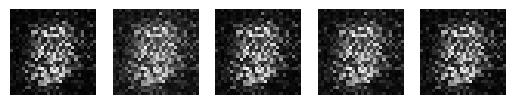

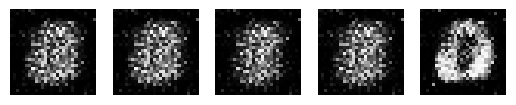

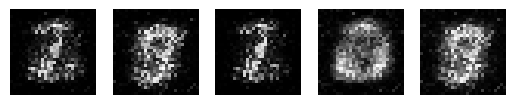

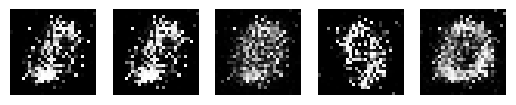

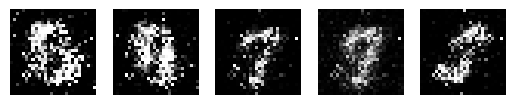

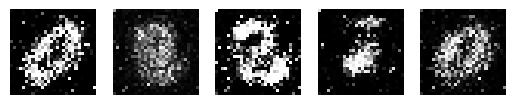

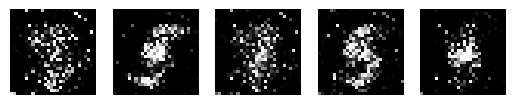

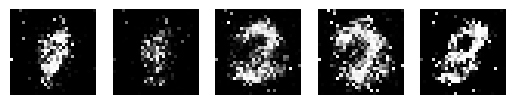

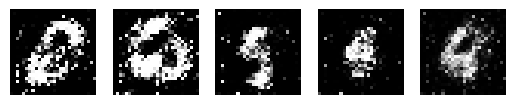

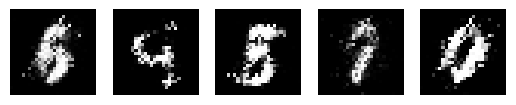

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 100
img_shape = (1, 28, 28)
batch_size = 64
epochs = 100

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss and optimizer
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Load data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])
dataloader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Ground truths
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # Train discriminator
        real_imgs = imgs
        optimizer_D.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        d_loss_real = adversarial_loss(discriminator(real_imgs), valid)
        d_loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

    #print(f"[Epoch {epoch + 1}/{epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    if epoch % 10 == 0:
        gen_imgs = gen_imgs[:5].detach().cpu().numpy()
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale back to [0, 1]
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(gen_imgs[i, 0], cmap="gray")
            plt.axis("off")
        plt.show()
